C:\Users\arvin\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


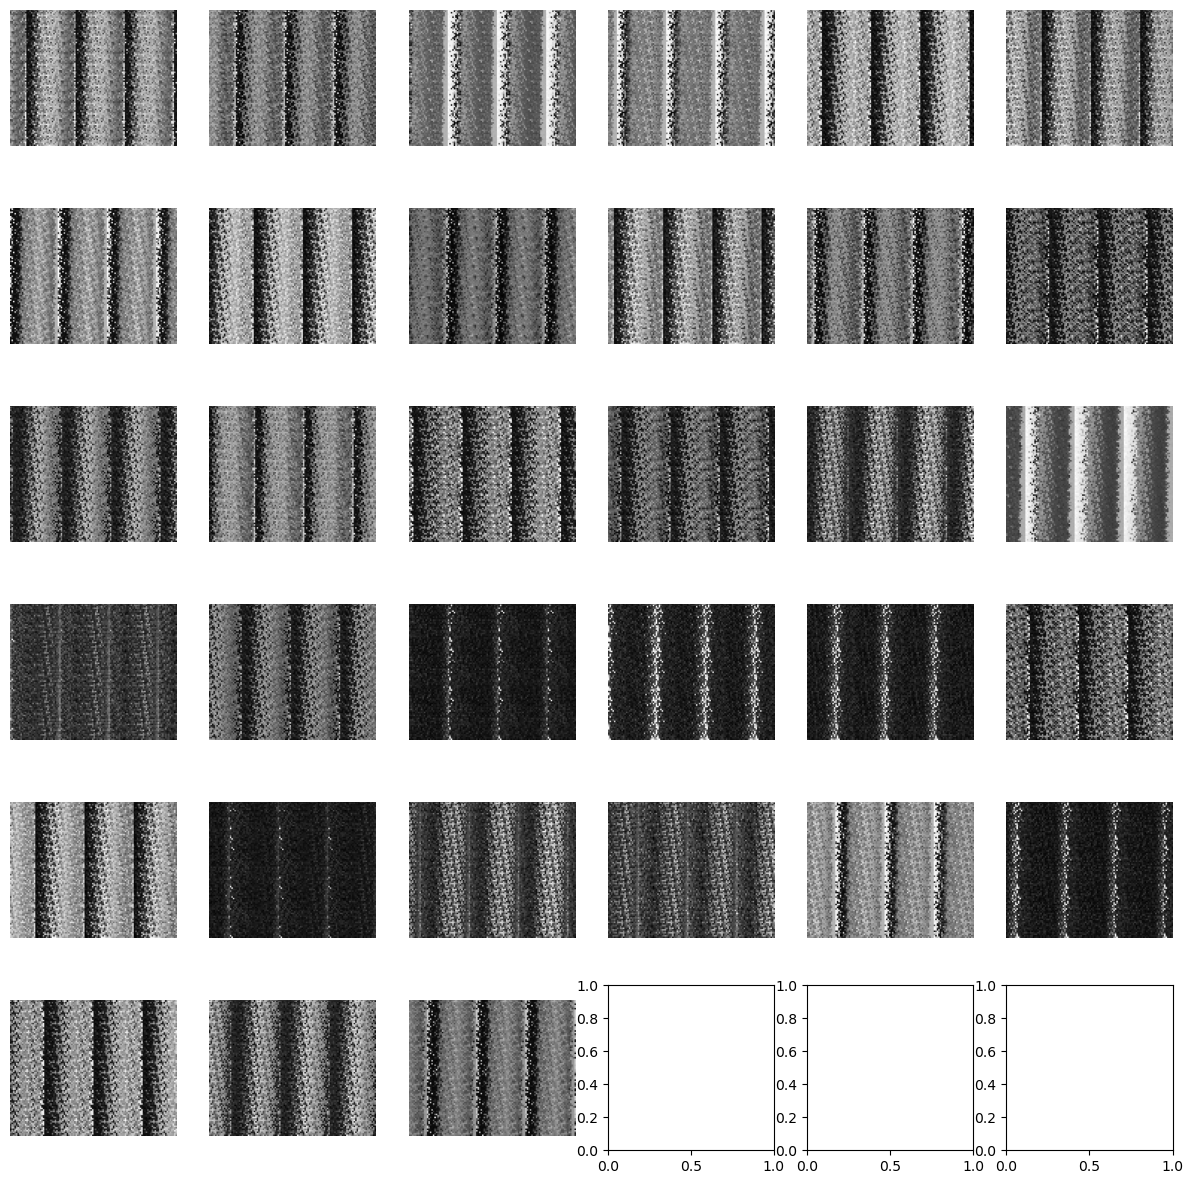

In [21]:
# 1. 5 Points. Explore the MDS-embedding of the 33 faces on top two eigenvectors: order the faces according
# to the top 1st eigenvector and visualize your results with figures.

import numpy as np
from scipy.io import loadmat
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Load the face data from a MATLAB file
data = loadmat(r"C:\Users\arvin\Downloads\face.mat")

# Access the data matrix
Y = data['Y']

# Flatten the 3D array into a 2D matrix
X = Y.reshape((Y.shape[2], -1))

# Calculate pairwise dissimilarity matrix
dissimilarity_matrix = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, axis=-1))

# Perform MDS
mds = MDS(n_components=2, dissimilarity='precomputed')
X_mds = mds.fit_transform(dissimilarity_matrix)

# Order the faces based on the top 1st eigenvector
embedding = X_mds[:, 0]
order = np.argsort(embedding)

# Visualize the results in a 6x6 grid with larger images
fig, axes = plt.subplots(6, 6, figsize=(15, 15))  # Increase the figsize for larger images
for i in range(33):
    ax = axes[i // 6, i % 6]
    ax.imshow(X[order[i], :].reshape((112, 92)).T, cmap='gray')  # Transpose for correct display
    ax.axis('off')
plt.show()


In [ ]:
                --------------------------------------- 2nd ---------------------------------------------------------

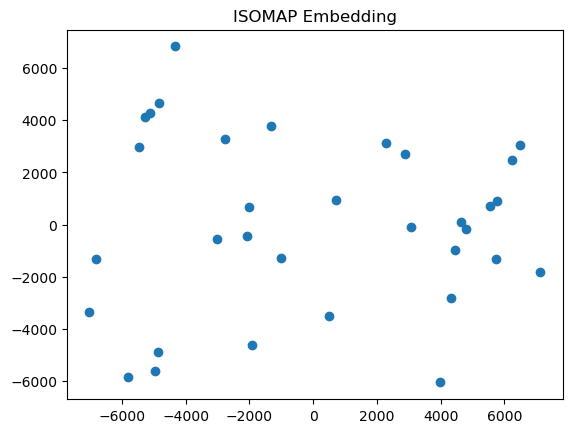

In [22]:
# 2  Explore the ISOMAP-embedding of the 33 faces on the k = 5 nearest neighbor graph and
#   compare it against the MDS results.
    
import numpy as np
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# Assuming you have loaded your data into X
# X should be a numpy array of shape (number_of_samples, number_of_features)

# Perform ISOMAP
k = 5  # Number of neighbors to consider
n_components = 2  # Number of dimensions for the embedding
isomap = Isomap(n_neighbors=k, n_components=n_components)
embedding_isomap = isomap.fit_transform(X)

# Visualize ISOMAP results
plt.figure()
plt.scatter(embedding_isomap[:, 0], embedding_isomap[:, 1])
plt.title('ISOMAP Embedding')
plt.show()


In [8]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.sparse import lil_matrix, coo_matrix, issparse
from scipy.sparse.linalg import eigsh
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt  # Added import

def isomapII(D, n_fcn, n_size, options):
    # Initialization and Parameters
    if 'dims' not in options:
        options['dims'] = list(range(1, 11))
    if 'overlay' not in options:
        options['overlay'] = 1
    if 'comp' not in options:
        options['comp'] = 1
    if 'display' not in options:
        options['display'] = 1
    if 'verbose' not in options:
        options['verbose'] = 1
    if 'landmarks' not in options:
        options['landmarks'] = list(range(1, len(D) + 1))

    dims = options['dims']
    comp = options['comp']
    overlay = options['overlay']
    displ = options['display']
    verbose = options['verbose']
    landmarks = options['landmarks']
    use_dijk = options.get('dijkstra', 1)

    Y = {}
    R = np.zeros(len(dims))

    # Step 1: Construct neighborhood graph
    if issparse(D) and not use_dijk:
        if n_fcn == 'k':
            ind = np.argsort(D, axis=1)
            for i in range(len(D)):
                D[i, ind[i, (2 + n_size):]] = np.inf
                if verbose == 1 and i % 50 == 0:
                    print('Iteration:', i, 'Estimated time to completion:', (len(D) - i) * tic / 60 / 50, 'minutes')
                    tic = 0
        elif n_fcn == 'epsilon':
            D = D / (D <= n_size)
            D = np.minimum(D, np.inf)
    D = np.minimum(D, D.T)  # Make sure distance matrix is symmetric

    if overlay == 1:
        if use_dijk:
            [a, b, c] = hierarchy.find(D)
            E = coo_matrix((np.ones(a.shape[0]), (a, b)), shape=(len(D), len(D)))
        else:
            [a, b, c] = hierarchy.find(D)
            E = lil_matrix((np.ones(len(a)), (a, b)), shape=(len(D), len(D)))
    else:
        E = None

    # Print statements for debugging
    print("Finished Step 1")

    # Step 2: Compute shortest paths
    if use_dijk:
        if issparse(D):
            D = distance_matrix(D, landmarks)
        else:
            Di = np.zeros(len(D) * len(landmarks))
            Dj = np.zeros(len(D) * len(landmarks))
            Ds = np.zeros(len(D) * len(landmarks))
            counter = 0
            a, b = np.where(D)
            for i in range(len(D)):
                l = np.where(a == i)
                g, f = np.sort(c[l])
                Di[counter + np.arange(len(landmarks))] = i
                Dj[counter + np.arange(len(landmarks))] = b[l[f[:len(landmarks)]]]
                Ds[counter + np.arange(len(landmarks))] = g[:len(landmarks)]
                counter += len(landmarks)
            D = coo_matrix((Ds[:counter], (Di[:counter], Dj[:counter])), shape=(len(D), len(D)))
    if overlay == 1:
        a, b = np.where(D)
        E = coo_matrix((np.ones(len(a)), (a, b)), shape=(len(D), len(D)))

    # Print statements for debugging
    print("Finished Step 2")

    # Continue with the rest of the code...
    # Step 3: Construct low-dimensional embeddings (Classical MDS)
    # Remove outliers from the graph
    if use_dijk:
        firsts = np.argmin(D, axis=1)
    else:
        firsts = np.argmin(D, axis=0)
    comps, I, J = np.unique(firsts, return_inverse=True)
    n_comps = len(comps)
    size_comps = np.sum(repmat(firsts, n_comps, 1) == ((np.arange(1, n_comps + 1) * np.ones(1, len(D))) - 1).T)
    tmp = np.sort(size_comps)
    comp_order = tmp[::-1]
    comps = comps[comp_order]
    size_comps = size_comps[comp_order]
    if comp > n_comps:
        comp = 1
    Y_index = np.where(firsts == comps[comp])
    Y_index = np.setdiff1d(Y_index, np.where(np.isinf(np.min(D, axis=1))))
    N = len(Y_index)
    if issparse(D):
        options['dims'] = np.unique(np.minimum(dims, nl - 1))
    if nl == N:
        opt = {'disp': 0}
        D2 = D ** 2
        M = np.eye(N) - np.ones((N, N)) / N
        B = -0.5 * (M @ D2 @ M)
        val, vec = eigsh(B, k=max(dims), which='LR', mode='buckling')
    else:
        subB = -0.5 * (D ** 2 - np.sum(D.T ** 2, axis=1).T / nl - np.ones((N, 1)) * np.sum(D ** 2, axis=1) / N + np.sum(np.sum(D ** 2)) / (N ** 2))
        opt = {'disp': 0}
        BBt = subB @ subB.T
        val, vec = eigsh(BBt, k=max(dims), which='LR', mode='buckling')
        val = np.real(val) ** 0.5
        vec = subB @ vec

    R2 = 1 - np.corrcoef(np.reshape(np.real(Y.coords[di]), (N * nl, 1)), D) ** 2
    R = R2[1, 0]
    if verbose == 1:
        print('Isomap on', N, 'points with dimensionality', dims[di], '--> residual variance =', R)

    if displ == 1:
        # Plot fall-off of residual variance with dimensionality
        plt.figure()
        plt.plot(dims, R, 'bo')
        plt.plot(dims, R, 'b-')
        plt.ylabel('Residual variance')
        plt.xlabel('Isomap dimensionality')

        # Plot two-dimensional configuration
        twod = np.where(dims == 2)[0]
        if len(twod) > 0:
            plt.figure()
            plt.plot(Y.coords[twod][0, :], Y.coords[twod][1, :], 'ro')
            if overlay == 1:
                # Implement the overlay code here if needed
                pass
            else:
                plt.title('Two-dimensional Isomap')
            plt.show()


In [ ]:
-----------------------------------   3rd  ------------------------------------------

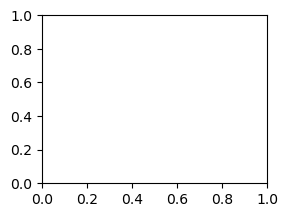

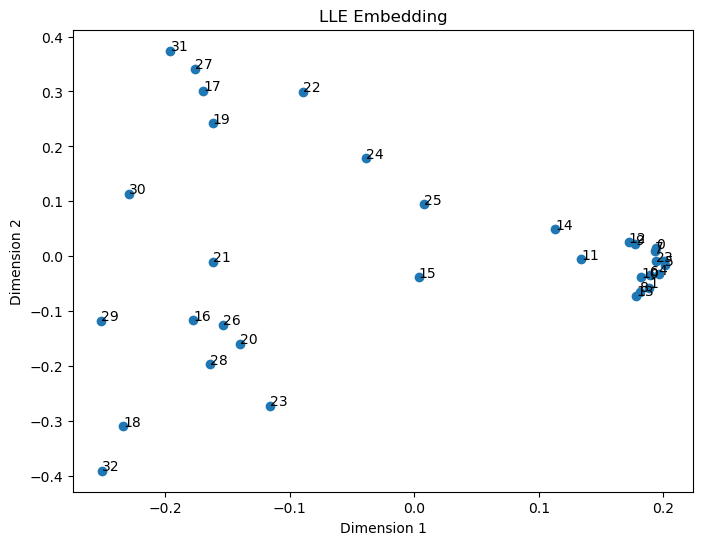

In [23]:
# 3. Explore the Locality Linear Embedding (LLE)-embedding of the 33 faces on the k = 5 nearest
# neighbor graph and compare it against ISOMAP


from sklearn.manifold import MDS, LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_neighbors=5, n_components=2, eigen_solver='dense',max_iter=1,n_jobs = 4)
X_lle = lle.fit_transform(X)
plt.subplot(223)
plt.figure(figsize=(8, 6))

plt.scatter(X_lle[:, 0], X_lle[:, 1])
plt.title('LLE Embedding')

for i in range(33):
    plt.annotate(str(i), (X_lle[i, 0], X_lle[i, 1]))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

plt.show()

In [ ]:
-------------------------------------------------- 4th --------

C:\Users\arvin\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


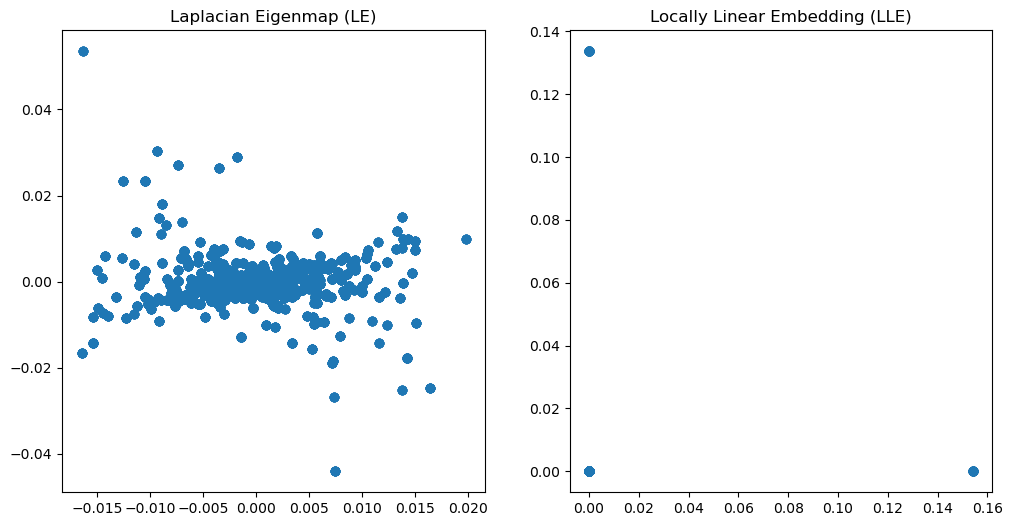

In [24]:
# 4. 5 Points. Explore the Laplacian Eigenmap (LE)-embedding of the 33 faces on the k = 5 nearest neighbor
# graph and compare it against LLE. Note: you may try the following Matlab code (le.m).

import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding, LocallyLinearEmbedding
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.neighbors import NearestNeighbors

# Load the dataset
data = loadmat('face.mat')
Y = data['Y']  # The dataset contains the faces

# Reshape the data into a data matrix X
n, p = Y.shape[2], Y.shape[0] * Y.shape[1]
X = np.reshape(Y, (n, p)).T

# Create a nearest neighbor graph
n_neighbors = 5
nn = NearestNeighbors(n_neighbors=n_neighbors)
nn.fit(X)
neighbors_indices = nn.kneighbors(X, return_distance=False)

# Perform Laplacian Eigenmap (LE) embedding
embedding_le = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=n_neighbors)
X_le = embedding_le.fit_transform(X)

# Perform Locally Linear Embedding (LLE)
n_neighbors_lle = 5
embedding_lle = LocallyLinearEmbedding(n_neighbors=n_neighbors_lle, n_components=2, method='standard')
X_lle = embedding_lle.fit_transform(X)

# Visualize the embeddings
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(X_le[:, 0], X_le[:, 1])
plt.title('Laplacian Eigenmap (LE)')

plt.subplot(122)
plt.scatter(X_lle[:, 0], X_lle[:, 1])
plt.title('Locally Linear Embedding (LLE)')

plt.show()
